### Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import linregress
import json
import math
import numpy as np
from scipy.optimize import curve_fit
import statistics as stat
import matplotlib.colors as mcolors
from scipy.stats import mannwhitneyu
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.decomposition import PCA
from goatools.obo_parser import GODag

### Functional differentiation between stages

##### Data loading

In [1]:
#load OE expression data
oe_tpm = pd.read_csv('../data/oe_tpm_counts_kallisto.csv', index_col=0)
#log transform
oe_log_tpm = np.log(oe_tpm + 1)
#remove suffix
oe_log_tpm.columns = oe_log_tpm.columns.str.replace(r'-v1\.0\.a2$', '', regex=True)

#load GO data
oe_gene_go_data = pd.read_csv('../data/OE_RNA_scaffolded_interproscan.csv')
go_dag = GODag("../data/go-basic.obo")

# Function to get the first GO term and map to biological process
def get_biological_process(go_terms):
    if pd.isna(go_terms):
        return None
    first_go = go_terms.split(',')[0].strip()
    if first_go in go_dag:
        return go_dag[first_go].name
    else:
        return None

oe_gene_go_data['biological_process'] = oe_gene_go_data['GO Terms'].apply(get_biological_process)

# Remove ".m01" from "mRNA" column
oe_gene_go_data['mRNA'] = oe_gene_go_data['mRNA'].str.replace(r'\.m\d+$', '', regex=True)

# Group by "mRNA" and keep the first "biological_process" in each group
oe_go_df = oe_gene_go_data.groupby('mRNA').first().reset_index()

# Select only the "mRNA" and "biological_process" columns
oe_go_df = oe_go_df[['mRNA', 'biological_process']]

#############################################################################################
#get cellular component
# Function to get the first GO term and map to Cellular Component
def get_cellular_component(go_terms):
    if pd.isna(go_terms):
        return None
    first_go = go_terms.split(',')[0].strip()
    if first_go in go_dag:
        term = go_dag[first_go]
        if term.namespace == 'cellular_component':
            return term.name
    return None

# Apply function to retrieve Cellular Component terms
oe_gene_go_data['cellular_component'] = oe_gene_go_data['GO Terms'].apply(get_cellular_component)

# Remove ".m01" from "mRNA" column
oe_gene_go_data['mRNA'] = oe_gene_go_data['mRNA'].str.replace(r'\.m\d+$', '', regex=True)

# Group by "mRNA" and keep the first "cellular_component" in each group
oe_go_df_cell_comp = oe_gene_go_data.groupby('mRNA').first().reset_index()

# Select only the "mRNA" and "cellular_component" columns
oe_go_df_cell_comp = oe_go_df_cell_comp[['mRNA', 'cellular_component']]

# Reset the index of oe_log_tpm to merge on the gene ids (columns)
oe_log_tpm_melted = oe_log_tpm.reset_index().melt(id_vars='index', var_name='mRNA', value_name='expression')
oe_log_tpm_melted = oe_log_tpm_melted.rename(columns={'index': 'sample_id'})

# Merge with oe_go_df to include biological processes
merged_df = oe_log_tpm_melted.merge(oe_go_df, on='mRNA', how='left')
cell_comp_merged_df = oe_log_tpm_melted.merge(oe_go_df_cell_comp, on='mRNA', how='left')

# Group by sample_id and biological_processes and sum the expression values
biological_process_grouped_df = merged_df.groupby(['sample_id', 'biological_process']).agg({'expression': 'sum'}).reset_index()

# Group by sample_id and cellular components and sum the expression values
cellular_component_grouped_df = cell_comp_merged_df.groupby(['sample_id', 'cellular_component']).agg({'expression': 'sum'}).reset_index()

# Pivot the table to have molecular function as columns and sample ids as index
cellular_component_df = cellular_component_grouped_df.pivot(index='sample_id', columns='cellular_component', values='expression').fillna(0)

# Pivot the table to have biological processes as columns and sample ids as index
biological_process_df = biological_process_grouped_df.pivot(index='sample_id', columns='biological_process', values='expression').fillna(0)

#Add stages
biological_process_df['Stage'] = biological_process_df.index.str[5]
cellular_component_df['Stage'] = cellular_component_df.index.str[5]

NameError: name 'pd' is not defined

In [5]:
biological_process_df.to_csv('../data/biological_processes_investment_data.csv')
cellular_component_df.to_csv('../data/cellular_component_investment_data.csv')

##### PCA

In [3]:
#biological processes
bio_proc_pca = PCA(n_components=2)
bio_proc_pca_result = bio_proc_pca.fit_transform(biological_process_df.drop(columns='Stage'))
# Create a DataFrame for the PCA results
bio_proc_pca_df = pd.DataFrame(data=bio_proc_pca_result, columns=['PC1', 'PC2'])
bio_proc_pca_df['Stage'] = biological_process_df['Stage'].values
# Get explained variance ratio
explained_variance = bio_proc_pca.explained_variance_ratio_
print("Explained variance by PC1:", explained_variance[0])
print("Explained variance by PC2:", explained_variance[1])

Explained variance by PC1: 0.9722164600678282
Explained variance by PC2: 0.0174943393708003


In [4]:
#cellular components
cell_comp_pca = PCA(n_components=2)
cell_comp_pca_result = cell_comp_pca.fit_transform(cellular_component_df.drop(columns='Stage'))
# Create a DataFrame for the PCA results
cell_comp_pca_df = pd.DataFrame(data=cell_comp_pca_result, columns=['PC1', 'PC2'])
cell_comp_pca_df['Stage'] = cellular_component_df['Stage'].values
# Get explained variance ratio
explained_variance = cell_comp_pca.explained_variance_ratio_
print("Explained variance by PC1:", explained_variance[0])
print("Explained variance by PC2:", explained_variance[1])

Explained variance by PC1: 0.9595408722948118
Explained variance by PC2: 0.01988970783905411


##### Plot

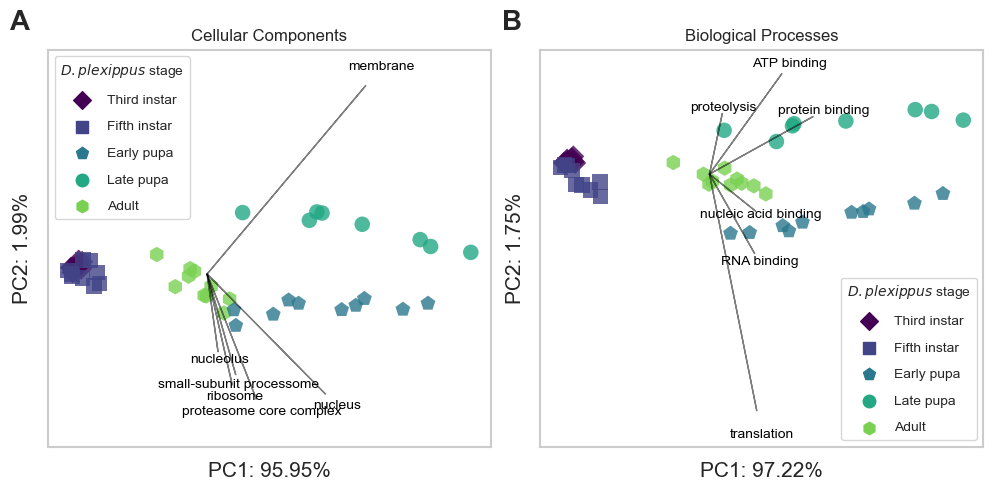

In [5]:
sns.set_style("white")
#define color palette
# Get the "Spectral" colormap
cmap = plt.cm.get_cmap('viridis')

# Divide the colormap into 14 bins
num_bins = 5
colors = [cmap(i / num_bins) for i in range(num_bins)]
# Extract hex codes
colors = [mcolors.to_hex(color) for color in colors]
#make palette
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))
hue_order = ['3', '5', 'E', 'L', 'A']

#plot cellular components
# Plot PCA results
sns.scatterplot(x='PC1', y='PC2', hue='Stage', style = 'Stage', 
                data=cell_comp_pca_df, ax=ax1, markers=['D', 's', 'h', 'p', 'o'],
               s=125, alpha=0.8, edgecolor = 'none', hue_order=hue_order)

# Compute the magnitude of the loadings and select the top 5
loadings = cell_comp_pca.components_.T
magnitudes = np.sqrt(np.sum(loadings**2, axis=1))
top_indices = np.argsort(magnitudes)[-6:]

# Define a scaling factor for better visibility of vectors
scaling_factor = 100

# Add vectors for the top 5 biological processes
for i in top_indices:
    ax1.arrow(0, 0, loadings[i, 0]*scaling_factor, loadings[i, 1]*scaling_factor, color='black', alpha=0.5)
    label = cellular_component_df.columns[i]
    if label == "proteasome core complex, alpha-subunit complex":
        label = "proteasome core complex"
    ax1.text(loadings[i, 0]*scaling_factor*1.1, loadings[i, 1]*scaling_factor*1.1, label, 
             color='black', ha='center', va='center', fontsize=10)
    
ax1.set_xlabel('PC1: 95.95%', size=15)
ax1.set_ylabel('PC2: 1.99%', size=15)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

handles, previous_labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, 
           labels=['Third instar', 'Fifth instar', 'Early pupa', 'Late pupa', 'Adult'], 
           loc='upper left', borderaxespad=0.5, fontsize=10, title=r'${D. plexippus}$ stage', 
           title_fontsize = 10, labelspacing = 1, markerscale=1.5)

ax1.set_ylim(-50, 65)

# Set the outer border color and linewidth for the figure
border_width = 1.5
ax1.spines['top'].set_color('#cccccc')
ax1.spines['top'].set_linewidth(border_width)
ax1.spines['bottom'].set_color('#cccccc')
ax1.spines['bottom'].set_linewidth(border_width)
ax1.spines['left'].set_color('#cccccc')
ax1.spines['left'].set_linewidth(border_width)
ax1.spines['right'].set_color('#cccccc')
ax1.spines['right'].set_linewidth(border_width)

ax1.set_title('Cellular Components')

#################################################################
#plot biological processes

# Plot PCA results
sns.scatterplot(x='PC1', y='PC2', hue='Stage', style = 'Stage', 
                data=bio_proc_pca_df, ax=ax2, markers=['D', 's', 'h', 'p', 'o'],
               s=125, alpha=0.8, edgecolor = 'none', hue_order=hue_order)

# Compute the magnitude of the loadings and select the top 5
loadings = bio_proc_pca.components_.T
magnitudes = np.sqrt(np.sum(loadings**2, axis=1))
top_indices = np.argsort(magnitudes)[-6:]

# Define a scaling factor for better visibility of vectors
scaling_factor = 400

# Add vectors for the top 5 biological processes
for i in top_indices:
    ax2.arrow(0, 0, loadings[i, 0]*scaling_factor, loadings[i, 1]*scaling_factor, color='black', alpha=0.5)
    ax2.text(loadings[i, 0]*scaling_factor*1.1, loadings[i, 1]*scaling_factor*1.1, biological_process_df.columns[i], 
             color='black', ha='center', va='center', fontsize=10)
    
ax2.set_xlabel('PC1: 97.22%', size=15)
ax2.set_ylabel('PC2: 1.75%', size=15)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

handles, previous_labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, 
           labels=['Third instar', 'Fifth instar', 'Early pupa', 'Late pupa', 'Adult'], 
           loc='lower right', borderaxespad=0.5, fontsize=10, title=r'${D. plexippus}$ stage', 
           title_fontsize = 10, labelspacing = 1, markerscale=1.5)

ax2.set_ylim(-350, 160)

# Set the outer border color and linewidth for the figure
border_width = 1.5
ax2.spines['top'].set_color('#cccccc')
ax2.spines['top'].set_linewidth(border_width)
ax2.spines['bottom'].set_color('#cccccc')
ax2.spines['bottom'].set_linewidth(border_width)
ax2.spines['left'].set_color('#cccccc')
ax2.spines['left'].set_linewidth(border_width)
ax2.spines['right'].set_color('#cccccc')
ax2.spines['right'].set_linewidth(border_width)

ax2.set_title('Biological Processes')

ax1.text(-0.04, 1.1, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax2.text(-0.04, 1.1, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../figures/primary/figure1.pdf')

Biological interpretations

In the early pupal stage, OE increases investment in the nucleolus, small-subunit processome, ribosome, and nucleus. This suggests that OE is highly active and possibly undergoing rapid growth, division, or responding to environmental or developmental cues that require significant changes in protein and RNA dynamics. This interpretation is consistent with the over-representation of biological processes such as translation, RNA binding, and nucleic acid binding, further indicating a robust engagement in protein synthesis and gene regulation. 

During the early pupal stage, OE also increases investment in proteosomes. However, it isn't until the late pupal stage that OE increas investment in proteolysis. This could suggest that investment in proteasomes during ther early pupal stages is preparation for more significant cellular differentiation or the removal of proteins that are no longer needed as OE transitions into a new developmental phase. 

During the late pupal stage, OE also invests in membrane formation, as well at ATP binding and protien binding. Increased protein binding indicates OE's focus on interactions critical for cellular function and development. This could involve protein-protein interactions necessary for complex formation, signal transduction pathways, or regulatory mechanisms that influence OE's physiological responses. Enhanced membrane investment likely supports OE's adaptation to new environmental conditions or cellular functions requiring specialized membrane structures. Increased ATP binding reflects OE's heightened energy demands, possibly due to active metabolic processes associated with growth, differentiation, or environmental responses. Emphasis on protein binding indicates OE's engagement in complex molecular interactions essential for regulatory processes, structural integrity, and functional specialization. The late pupal phase is crucial for OE's final preparations before transitioning into adulthood. Investments in membrane dynamics, ATP binding, and protein interactions likely facilitate OE's physiological maturation, adaptation to ecological niches, and readiness for functional roles as an adult parasite.



Biological Interpretation

The over-representation of these terms suggests a cellular state characterized by active protein synthesis (nucleolus, small-subunit processome, ribosome), protein quality control and degradation (proteasome), and overall nuclear activities (nucleus). Biologically, this could imply that the cells in this sample group are in a highly active state, possibly undergoing rapid growth, division, or responding to environmental or developmental cues that require significant changes in protein and RNA dynamics.

Potential Scenarios

Rapid Cell Proliferation: Cells might be proliferating rapidly, requiring increased ribosome biogenesis and protein synthesis to support cell growth and division.

Developmental Changes: The sample group might be undergoing specific developmental stages that necessitate increased transcriptional activity and protein turnover.

### Stage specificity and transcriptional turnover

##### Functions

In [2]:
#A function to calculate specificity index (tau) for a row in a pandas data frame
def compute_tau(row):
    if max(row) != 0:
        #normalize to maximal component value
        normalized_row = [value / max(row) for value in row]
        row_to_sum = [1-value for value in normalized_row]
        row_sum = sum(row_to_sum)
        n_minus_1 = len(normalized_row) - 1
        tau = row_sum / n_minus_1
        return tau
    else:
        return 'NA'
    
# Function to extract treatment from sample id
def extract_treatment(sample_id):
    return sample_id[5]

##### Data Loading

Stage Specificity

In [3]:
#load oe_expression_data
oe_tpm_counts = pd.read_csv('../data/oe_tpm_counts_kallisto.csv', index_col=0)

#get mean by stage

# Apply the function to extract treatment for each sample
oe_tpm_counts['dplex-stage'] = list(oe_tpm_counts.index.map(extract_treatment))

# Group by the Treatment and calculate mean for each gene
oe_mean_tpm_counts_by_stage = oe_tpm_counts.groupby('dplex-stage').mean()

#add pseudo count
oe_mean_tpm_counts_by_stage += 1

# Reordering developmental stages
dev_stages = ['3', '5', 'E', 'L', 'A']
oe_mean_tpm_counts_by_stage = oe_mean_tpm_counts_by_stage.reindex(dev_stages)

#log transform
log_oe_mean_tpm_counts_by_stage = np.log(oe_mean_tpm_counts_by_stage)

#transpose
log_oe_mean_tpm_counts_by_stage = log_oe_mean_tpm_counts_by_stage.T


#load dplex expression data
dpl_tpm_counts = pd.read_csv('../data/dpl_inf_tpm_counts_kallisto.csv', index_col=0)

#get mean by stage

# Apply the function to extract treatment for each sample
dpl_tpm_counts['dplex-stage'] = list(dpl_tpm_counts.index.map(extract_treatment))

# Group by the Treatment and calculate mean for each gene
dpl_mean_tpm_counts_by_stage = dpl_tpm_counts.groupby('dplex-stage').mean()

#add pseudo count
dpl_mean_tpm_counts_by_stage += 1

# Reordering developmental stages
dev_stages = ['3', '5', 'E', 'L', 'A']
dpl_mean_tpm_counts_by_stage = dpl_mean_tpm_counts_by_stage.reindex(dev_stages)

#log transform
log_dpl_mean_tpm_counts_by_stage = np.log(dpl_mean_tpm_counts_by_stage)

#transpose
log_dpl_mean_tpm_counts_by_stage = log_dpl_mean_tpm_counts_by_stage.T

In [4]:
#OE Tau df
ids = []
tau_values = []

for index, row in log_oe_mean_tpm_counts_by_stage.iterrows():
    #add gene ids
    gene_id = index
    ids.append(gene_id)
    
    #add tau
    values = list(row[['3', '5', 'E', 'L', 'A']])
    tau = compute_tau(values)
    tau_values.append(tau)
    
oe_tau_data = {'gene_id' : ids, 'tau' : tau_values}
oe_tau_dataframe = pd.DataFrame(oe_tau_data)

#write to csv
oe_tau_dataframe.to_csv('../data/oe_tau_dataframe.csv')

#Dplex tau df
ids = []
tau_values = []

for index, row in log_dpl_mean_tpm_counts_by_stage.iterrows():
    #add gene ids
    gene_id = index
    ids.append(gene_id)
    
    #add tau
    values = list(row[['3', '5', 'E', 'L', 'A']])
    tau = compute_tau(values)
    tau_values.append(tau)
    
dpl_tau_data = {'gene_id' : ids, 'tau' : tau_values}
dpl_tau_dataframe = pd.DataFrame(dpl_tau_data)
dpl_tau_dataframe = dpl_tau_dataframe.loc[dpl_tau_dataframe['tau'] != 'NA']

In [ ]:
#write to csv
oe_tau_dataframe.to_csv('../data/oe_tau_dataframe.csv')
dpl_tau_dataframe.to_csv('../data/dpl_tau_dataframe.csv')

Transcriptional turnover 

Distances were calculated using Pearson correlation distances (transcriptional_turnover.R script).

OE

    Third to Fifth: 0.1889201
    Fifth to Early: 0.3552743
    Early to Late: 0.3858185
    Late to Adult: 0.3509303

Dplex

    Third to Fifth: 0.04877086
    Fifth to Early: 0.1263302
    Early to Late: 0.1201828
    Late to Adult: 0.0951506

In [11]:
oe_transcriptional_turnover_pearson = [0.1889201, 0.3552743, 0.3858185, 0.3509303]
dplex_transcriptional_turnover_pearson = [0.04877086, 0.1263302, 0.1201828, 0.0951506]
transitions = ['L3-L5', 'L5-PE', 'PE-PL', 'PL-A']

Transcriptional turnover correlation

In [7]:
pearson_data = pd.read_csv('../data/transcriptional_correlation_dplex_oe_pearson.csv')
#remove diagonal
pearson_data = pearson_data.loc[(pearson_data['oe.pearson.vector'] != 0) & (pearson_data['dplex.pearson.vector'] != 0)]

Transcriptional turnover 

Distances were calculated using Manhattan distances (transcriptional_turnover.R script). Note that data was not log transformed for this analysis. 

OE

    Third to Fifth: 48965.81
    Fifth to Early: 363241
    Early to Late: 781786.7
    Late to Adult: 805697.9

Dplex

    Third to Fifth: 798659.1
    Fifth to Early: 1224224
    Early to Late: 1179729
    Late to Adult: 930206.8

In [20]:
oe_transcriptional_turnover_manhattan = [48965.81, 363241, 781786.7, 805697.9]
dplex_transcriptional_turnover_manhattan = [798659.1, 1224224, 1179729, 930206.8]
transitions = ['L3-L5', 'L5-PE', 'PE-PL', 'PL-A']

##### Primary figures

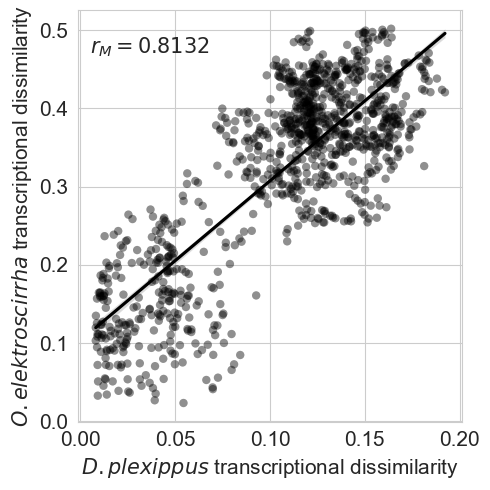

In [37]:
#plot
sns.set_style('whitegrid')

#plot
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

#Transcriptional divergence correlation
sns.regplot(y='oe.pearson.vector', x='dplex.pearson.vector', data=pearson_data, ax=ax1, scatter=False, color='black')
sns.scatterplot(y='oe.pearson.vector', x='dplex.pearson.vector', data=pearson_data, ax=ax1, color='black', edgecolor='none', alpha=0.25)

ax1.set_xlabel('$D. plexippus$ transcriptional dissimilarity', fontsize=15)
ax1.set_ylabel('$O. elektroscirrha$ transcriptional dissimilarity', fontsize = 15)

ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.text(0.005, 0.47, '$r_{M} = 0.8132$', fontsize=15)



plt.tight_layout()
plt.savefig('../figures/primary/figure2.pdf')

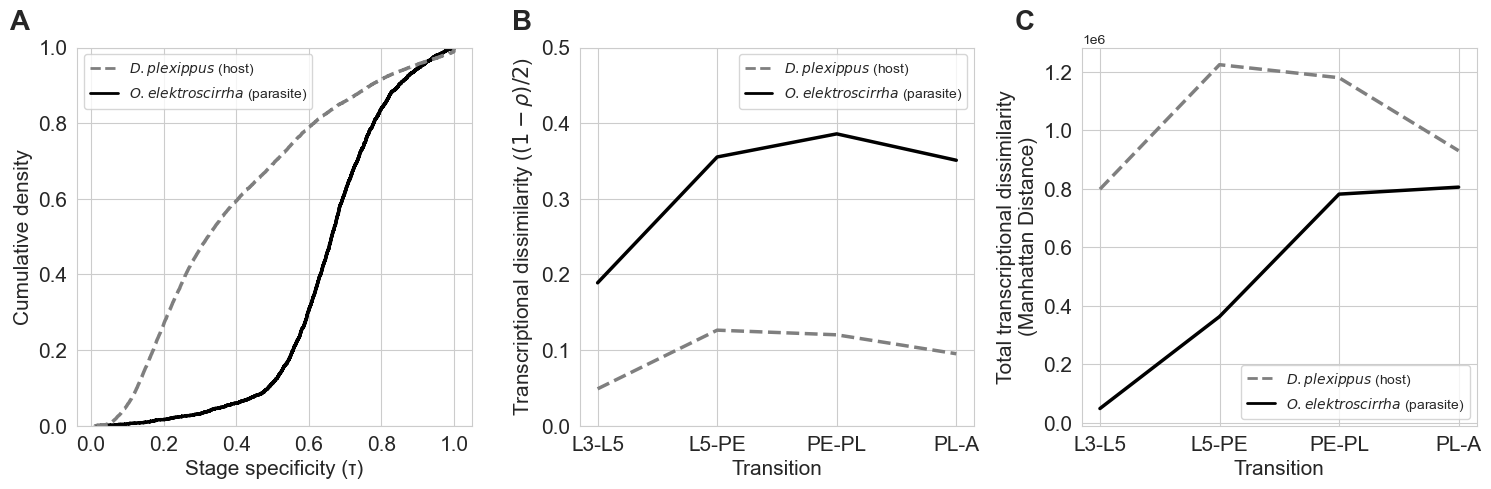

In [25]:
#plot
sns.set_style('whitegrid')

#plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))

# Stage-specificity
#Oe
sns.ecdfplot(data=oe_tau_dataframe, x="tau", ax=ax1, linewidth=2.5, ls='-', color='black')

#D.plex
sns.ecdfplot(data=dpl_tau_dataframe, x="tau", ax=ax1, linewidth=2.5, ls='--', color='tab:gray')

ax1.set_xlabel('Stage specificity (\u03C4)', fontsize = 15)
ax1.set_ylabel('Cumulative density', fontsize = 15)

ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)

#define legend
legend_lines = [mlines.Line2D([0], [0], color='tab:gray', label=r'${D. plexippus}$ (host)', linewidth=2, linestyle='--'),
                mlines.Line2D([0], [0], color='black', label=r'${O. elektroscirrha}$ (parasite)', linewidth=2)]

ax1.legend(handles=legend_lines, loc='upper left', fontsize=10)


#Transcriptional turnover magnitude comparison (Pearson)
#Dplex
sns.lineplot(y=dplex_transcriptional_turnover_pearson, x=transitions, ax=ax2, ls='--', color='tab:gray', linewidth=2.5)
#OE
sns.lineplot(y=oe_transcriptional_turnover_pearson, x=transitions, ax=ax2, linewidth=2.5, ls='-', color='black')

ax2.set_xlabel('Transition', fontsize = 15)
ax2.set_ylabel(r'Transcriptional dissimilarity ($(1-\rho)/2$)', fontsize = 15)

ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.set_ylim([0,0.5])

#define legend
legend_lines = [mlines.Line2D([0], [0], color='tab:gray', label=r'${D. plexippus}$ (host)', linewidth=2, linestyle='--'),
                mlines.Line2D([0], [0], color='black', label=r'${O. elektroscirrha}$ (parasite)', linewidth=2)]

ax2.legend(handles=legend_lines, loc='upper right', fontsize=10)

#Transcriptional turnover magnitude comparison (Manhattan)
#Dplex
sns.lineplot(y=dplex_transcriptional_turnover_manhattan, x=transitions, ax=ax3, ls='--', color='tab:gray', linewidth=2.5)
#OE
sns.lineplot(y=oe_transcriptional_turnover_manhattan, x=transitions, ax=ax3, linewidth=2.5, ls='-', color='black')

ax3.set_xlabel('Transition', fontsize = 15)
ax3.set_ylabel('Total transcriptional dissimilarity\n(Manhattan Distance)', fontsize = 15)

ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

#define legend
legend_lines = [mlines.Line2D([0], [0], color='tab:gray', label=r'${D. plexippus}$ (host)', linewidth=2, linestyle='--'),
                mlines.Line2D([0], [0], color='black', label=r'${O. elektroscirrha}$ (parasite)', linewidth=2)]

ax3.legend(handles=legend_lines, loc='lower right', fontsize=10)

ax1.text(-0.12, 1.1, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax2.text(-0.12, 1.1, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax3.text(-0.12, 1.1, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../figures/primary/figure3.pdf')

##### Statistics / Interpretations

<i>Stage-specificity comparison between Dplex and OE<i>

OE genes have significantly more stage biased patterns of expression (A):

In [34]:
#Kolmogorov–Smirnov test
statistic, p_value = stats.ks_2samp(list(oe_tau_dataframe['tau']), list(dpl_tau_dataframe['tau']))
print(f"Test statistic = {statistic}\nP value = {p_value}")

Test statistic = 0.5803434938420414
P value = 0.0


------------------

<i>Comparison of the extent of transcriptional turnover<i>

OE undergoes more transcriptional turnover than Dplex (B)

--------

<i>Correlation between Dplex and OE patterns of transcriptional dissimilarity.<i>

Transcriptional dissimilarity between Dplex individuals predicts transcriptional dissimilarity between OE populations (C).
    
Mantel test:

    Mantel statistic r: 0.8132 
          Significance: 0.001 
    
    Upper quantiles of permutations (null model):
       90%    95%  97.5%    99% 
    0.0455 0.0601 0.0785 0.0889 
    Permutation: free
    Number of permutations: 999
    
Also performed a redundancy analysis:
    
    R^2 = 0.8715082